# Session 7: Supervised Machine Learning (classification) 

In this guide we will perform traditional text classification using sparse text representations (TF-IDF) vectors
We will also examine image classification 
We will use the same set of models for both. 

### Data loading and preprocessing: text
We will be loading a corpus of Amazon reviews **labeled** for sentiment (positive or negative)


In [ ]:
# importing the Python's Pandas library for data loading and manipulation
import pandas as pd

# Step #1: loading our annotated reviews
train_data = pd.read_csv('reviews_train.csv', delimiter = '\t') # in our file, the values are actually TAB-separated
eval_data = pd.read_csv('reviews_test.csv', delimiter = '\t')

# let's see what our data actually looks like
train_data


 **SpaCy** (https://spacy.io/) is a library that offers a lot of functionality for text processing and many pretrained NLP models: 
 - tokenization
 - POS-tagging 
 - Syntactic parsing
 - Named entity recognition, 
 - and many more...

In [ ]:
# let us preprocess (tokenize and lemmatize) the texts
# install spacy with pip or conda, e.g., pip install spacy
import spacy

# wordcloud library displays texts as word clouds, based on word frequency statistics
import wordcloud

# wordcloud has its own list of STOPWORDS
from wordcloud import STOPWORDS

# removing the repetitions if there are any, converting the list to set
stopwords = set(list(STOPWORDS) + ['.', "?", "!", ",", "(", ")", ":", ";", "\"", "'"])
print(stopwords)



When we preprocess text for text classification, we often: 
- Remove stopwords (like "a", "the", "of", "in", "and")
- Lemmatize words (reduce different forms of the same word to a common form: houses -> house)


In [ ]:
# The model we want to load needs to be first downloaded: 
# in command line: python -m spacy download en_core_web_sm
# load the spacy models for English
nlp = spacy.load("en_core_web_sm")

train_data["tokens"] = train_data.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["tagger", "parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))])
eval_data["tokens"] = eval_data.content.apply(lambda x: [t.lemma_.lower() for t in nlp(x, disable=["tagger", "parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))])

train_data


## Traditional text classification 

### Converting texts into TF-IDF sparse vectors

- To this end we will use the existing functionality (TF-IDF vectorizer) from the Scikit-Learn library
- One could alternatively also use the CountVectorizer (as we did for in Session 6)

We have already seen the Scikit-Learn library in Python the last time. It offers many machine learning (but also text processing) methods, models, and tools that can be used out of the box with a very consistent and uniform API (same functions, like fit, transform, fit_transform, ...)

In [ ]:
# we will use the sklearn library for text preprocessing (and later also for classification and clustering algorithms/models)
import sklearn

# for this we need the TfidfVectorizer class from scikit-learn (sklearn) 
from sklearn.feature_extraction.text import TfidfVectorizer

# dummy function, returning our already tokenized text. TfidfVectorizer usually expects raw text and performs tokenization of
# its own. Since we already tokenized the texts ourselves with SpaCy, we just provide those tokens
def dummy(tokenized_text):
    return tokenized_text

# Converting Pandas data series into a list of tokenized texts (input format required by scikit-learn's TfidfVectorizer)
train_set = train_data["tokens"].tolist()
eval_set = eval_data["tokens"].tolist()

# initializing the TF-IDF vectorizer
vectorizer = TfidfVectorizer(tokenizer = dummy, preprocessor = dummy)

# vectorizer learns the vocabulary from the (tokenized) train set tweets
vectorizer.fit(train_set)

# let's see what the vocabulary looks like
print(vectorizer.vocabulary_)

print()

# let's see how many different words we have in our vocabulary
print(len(vectorizer.vocabulary_))

In [ ]:
# Step 2: Create TF-IDF vectors for train set and evaluation set reviews, convert the "string" labels into numeric labels

# Creating now TF-IDF vectors for train set, and then for evaluation set
train_tfidf_vectors = vectorizer.transform(train_set)
eval_tfidf_vectors = vectorizer.transform(eval_set)

# let's see what the TF-IDF vectors of training set tweets look like
print("Train set TF-IDF vectors")
print(train_tfidf_vectors.shape)
print()
print(train_tfidf_vectors)



In [ ]:
# Converting labels "POS" and "NEG" into numeric labels, as required by the logistic regression classifier

# for the train set
train_labels = train_data["label"].tolist()
train_labels = [(1 if tl == "POS" else 0) for tl in train_labels]

# for the evaluation set
eval_labels = eval_data["label"].tolist()
eval_labels = [(1 if el == "POS" else 0) for el in eval_labels]

# let's see what the TF-IDF labels of training set tweets look like
print("Train set labels")
print(train_labels)
print()
print("Test set labels")
print(eval_labels)


print(len(train_labels))
print(train_tfidf_vectors.shape[0])

### Model training (logistic regression) and evalution

In [ ]:
# Step 3: Train the logistic regression classifier on the training set

# For this we need the LogisticRegression class 
from sklearn.linear_model import LogisticRegression

# we now train ("fit") the logistic regression classifier by providing the training input (tf-idf vectors of train tweets) and 
# corresponding offensiveness labels for those tweets
classifier = LogisticRegression(C = 32, solver = 'lbfgs')
classifier.fit(train_tfidf_vectors, train_labels)

# the result is a trained classifier, which we can examine more closely in the next steps and make predictions with
print(classifier)

In [ ]:
# Step 4: Let's evaluate the accuracy of our classifier on evaluation tweets
# for this we can directly use the "score" function of the LogisticRegression classifier
accuracy = classifier.score(eval_tfidf_vectors, eval_labels)
print("Classification accuracy: " + str(accuracy * 100) + "%")

In [ ]:
classifier.coef_[0]

In [ ]:
# Step 5: Intepretability of the classifier: analysis of weights assigned to individual terms

# let's build a dictionary with words from our vocabulary as keys and their associated weights 
# (produced by the LogisticRegression) classifier as values

# initialize the empty dictionary
weights_dict = {}

# for each term in the "vectorizer.vocabulary_" (dict that maps terms to IDs)
for term in vectorizer.vocabulary_:
    # we add that term and look up the LR weight at the corresponding ID
    weights_dict[term] = classifier.coef_[0][vectorizer.vocabulary_[term]]

# let's sort terms according to their LR weights, from lowest (largest negative values) to highest (largest positive values) 
weights_sorted = list(sorted(weights_dict.items(), key=lambda item: item[1]))

# 20 terms with smallest weights (most indicative of the 0 class: "not offensive")
#print(weights_sorted[:100])

weights_sorted.reverse()
#print()
print(weights_sorted[:100])


#word = "fragile"
#word_w = classifier.coef_[0][vectorizer.vocabulary_[word]]
#print(word + ": " + str(word_w))





In [ ]:
# new texts
new_texts = ["I love this device"]

# tokenization & lemmatization of new texts
new_texts_tokenized = [[t.lemma_.lower() for t in nlp(x, disable=["tagger", "parser", "ner"]) if (t.text.strip() != "" and (t.text.lower() not in stopwords))] for x in new_texts]

print(new_texts_tokenized)

tf_idf_feats = vectorizer.transform(new_texts_tokenized)
print(tf_idf_feats)

print(classifier.predict(tf_idf_feats))
print(classifier.predict_proba(tf_idf_feats))

### Data loading and preprocessing: images
We will be loading a collection of images of handwritten digits (MNIST)

Keras is a library for deep learning, but we will just use it to load the MNIST dataset of images from it. You will have to install both keras and tensorflow libraries 

- pip install tensorflow
- pip install keras


60000 10000
(28, 28)
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0

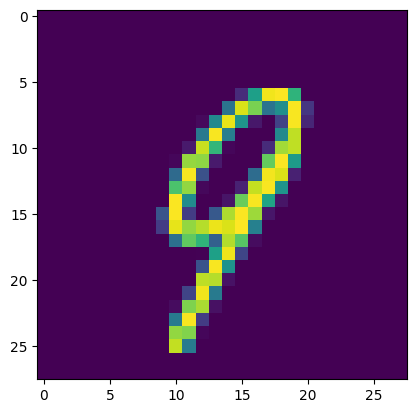

In [1]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# Loading the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data() 

print(len(X_train), len(X_test))

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.


print(X_train[0].shape)

print(X_train[22])
print(y_train[22])

plt.imshow(X_train[22])

In [3]:
# let's train the same classification algorithm as for text classification
# logistic regression
from sklearn.linear_model import LogisticRegression

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) 
print(X_train.shape)
# 60000 instances with 784 features each is a big dataset to train logistic regression

# reduce to 10000 examples
X_train = X_train[:10000]
y_train = y_train[:10000]

classifier = LogisticRegression(C = 1, solver = 'lbfgs')
classifier.fit(X_train, y_train)

(10000, 784)


C:\Goran\System\miniconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1)

In [4]:
# let's score its performance on the evaluation set

X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:]))) 

accuracy = classifier.score(X_test, y_test)
print("Classification accuracy: " + str(accuracy * 100) + "%")

Classification accuracy: 90.36%


In [5]:
# we can do exactly the same thing: training + prediction/evaluation with a different classifier -- SVM

from sklearn.svm import SVC 

# initialize classifier
classifier = SVC(C = 1, kernel = "rbf")

# train classifier
classifier.fit(X_train, y_train)

# predict and evaluate classifier
accuracy = classifier.score(X_test, y_test)
print("Classification accuracy: " + str(accuracy * 100) + "%")

Classification accuracy: 95.94%
